# Titanic

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
data = pd.read_csv('Titanic Data/train.csv')

## Tratamento

### Escolhendo as colunas

In [3]:
# Vamos ver as variáveis disponíveis
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

### Tratando valores nulos

In [5]:
# Quantos valores nulos temos por atributo
data.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [6]:
# Vamos remover Cabin por ter muitos valores nulos
data.drop(['Cabin'], axis=1, inplace=True)

In [7]:
# Vamos analisar a váriavel Age, para estudar a melhor forma de preencher valores nulos
data['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Distribuição da idade dos passageiros')

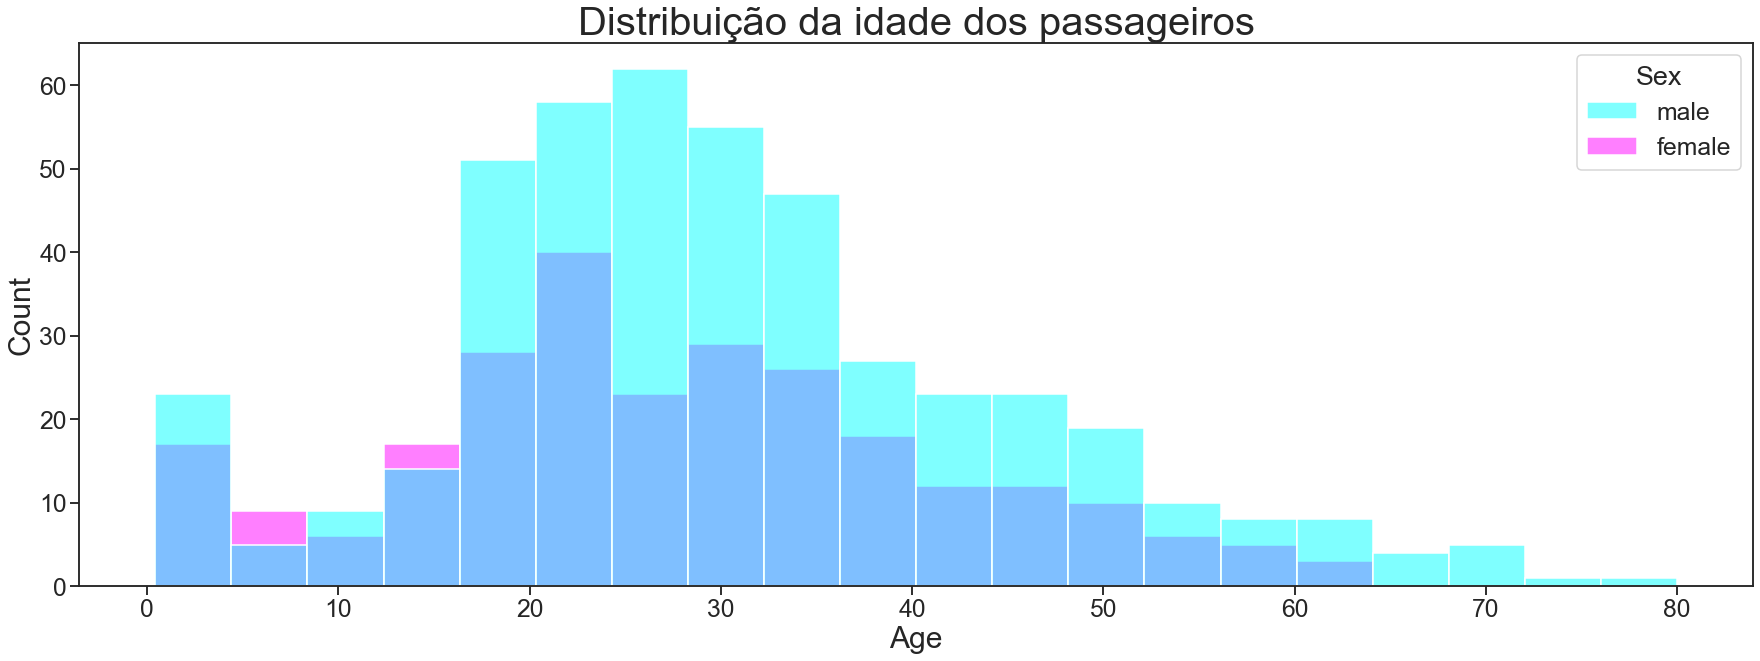

In [9]:
# Sua distribuição também

sns.set_style("ticks")
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(30, 10))
palette = sns.color_palette(['cyan', 'magenta'])
plot = sns.histplot(data=data, x="Age", hue ='Sex', palette=palette)
plot.set_xlabel("Age", fontsize=30) 
plot.set_ylabel("Count", fontsize=30)
plt.title("Distribuição da idade dos passageiros", fontsize=40)

In [10]:
# Vamos preencher com a média
data['Age'].fillna(data['Age'].mean(), inplace=True)

In [11]:
# Sobraram poucos valores nulos, então vamos remover essas entradas
data.dropna(inplace=True)

### Tratamento de tipo

In [12]:
# Verificando o tipo de cada variável
data.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [13]:
data['Sex'].unique()

array(['male', 'female'], dtype=object)

In [14]:
replace_gender = lambda s: 0 if s == 'male' else 1

data['Sex'] = data['Sex'].apply(replace_gender)

In [15]:
data['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [16]:
replace_S = lambda e: 1 if e == 'S' else 0
replace_C = lambda e: 1 if e == 'C' else 0
replace_Q = lambda e: 1 if e == 'Q' else 0

data['Embarked_S'] = data['Embarked'].apply(replace_S)
data['Embarked_C'] = data['Embarked'].apply(replace_C)
data['Embarked_Q'] = data['Embarked'].apply(replace_Q)

In [17]:
data.drop(['Embarked'], axis=1, inplace=True)

### Análise de correlação

<AxesSubplot:>

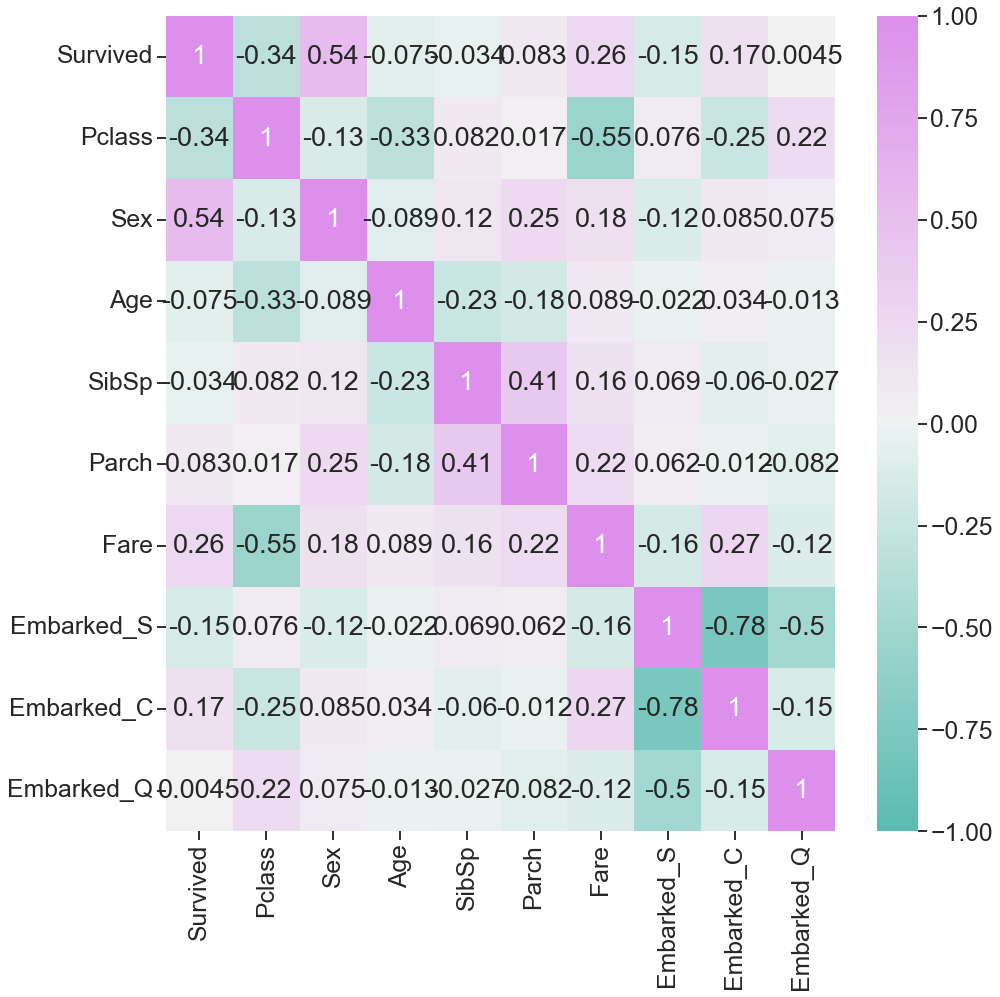

In [18]:
# matriz de correlação
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(15, 15))
palette = sns.diverging_palette(180,300, l=70, as_cmap=True)
sns.heatmap(data.corr(), annot=True, cmap=palette, vmin=-1, vmax=1)

In [19]:
cols= ['Survived', 'Pclass', 'Fare', 'Sex']

data = data[cols]

### Normalização

In [20]:
data['Fare'].describe()

count    889.000000
mean      32.096681
std       49.697504
min        0.000000
25%        7.895800
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [21]:
# Normalizaremos as variáveis não binárias
normalize = lambda x: (x - x.min()) / (x.max() - x.min())
data = data.apply(normalize)

In [22]:
data['Fare'].describe()

count    889.000000
mean       0.062649
std        0.097003
min        0.000000
25%        0.015412
50%        0.028213
75%        0.060508
max        1.000000
Name: Fare, dtype: float64

## Preparação

### Dataset e Dataloader

In [23]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [24]:
X_data = data.drop('Survived', axis=1).values
y_data = data['Survived'].values

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [26]:
class TitanicDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.float)

In [27]:
BATCH_SIZE = 64

train_dataloader = DataLoader(TitanicDataset(X_train, y_train), shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(TitanicDataset(X_val, y_val), shuffle=True, batch_size=BATCH_SIZE)

device = ( "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu")

## Arquitetura

In [28]:
import torch.nn as nn

In [29]:
class TitanicNN(nn.Module):
    def __init__(self,n_in=3,n_hid=6,n_out=1):
        super(TitanicNN,self).__init__()
        self.n_in  = n_in
        self.n_hid = n_hid
        self.n_out = n_out

        self.linear_layer =  nn.Sequential(nn.Linear(n_in,n_hid),
                             nn.ReLU(),
                             nn.Linear(n_hid,n_out),              
                             nn.Sigmoid())
        
    def forward(self,x):
        x = self.linear_layer(x)
        return x

In [30]:
model = TitanicNN()

loss_fn = nn.BCELoss()
LR = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

## Treinamento

In [31]:
def train(dataloader):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        y = y.type(torch.FloatTensor)
        X, y = X.to(device), y.to(device)

        pred = model(X)
        pred = pred.squeeze(1)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    return loss

In [32]:
def test(dataloader):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() 
    test_loss, correct = 0, 0
    with torch.no_grad(): 
        for X, y in dataloader:
            y = y.type(torch.FloatTensor)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            pred = pred.squeeze(1)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.round() == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [33]:
train_losses = []
test_losses = []
EPOCHS = 150
for t in range(EPOCHS):
    print(f'Epoch {t+1} -------------------------------')
    
    print('Train')
    train_losses.append(train(train_dataloader))
    
    print('Test')
    test_losses.append(test(val_dataloader))

Epoch 1 -------------------------------
Train
Test
Accuracy: 38.8%, Avg loss: 0.793919 

Epoch 2 -------------------------------
Train
Test
Accuracy: 38.8%, Avg loss: 0.778160 

Epoch 3 -------------------------------
Train
Test
Accuracy: 38.8%, Avg loss: 0.766917 

Epoch 4 -------------------------------
Train


/tmp/ipykernel_16545/1549261356.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.data[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.float)


Test
Accuracy: 38.8%, Avg loss: 0.757812 

Epoch 5 -------------------------------
Train
Test
Accuracy: 38.8%, Avg loss: 0.747622 

Epoch 6 -------------------------------
Train
Test
Accuracy: 38.8%, Avg loss: 0.741021 

Epoch 7 -------------------------------
Train
Test
Accuracy: 38.8%, Avg loss: 0.732013 

Epoch 8 -------------------------------
Train
Test
Accuracy: 39.3%, Avg loss: 0.725119 

Epoch 9 -------------------------------
Train
Test
Accuracy: 39.3%, Avg loss: 0.716304 

Epoch 10 -------------------------------
Train
Test
Accuracy: 39.3%, Avg loss: 0.710681 

Epoch 11 -------------------------------
Train
Test
Accuracy: 39.3%, Avg loss: 0.703633 

Epoch 12 -------------------------------
Train
Test
Accuracy: 42.7%, Avg loss: 0.695652 

Epoch 13 -------------------------------
Train
Test
Accuracy: 65.7%, Avg loss: 0.688765 

Epoch 14 -------------------------------
Train
Test
Accuracy: 65.7%, Avg loss: 0.682041 

Epoch 15 -------------------------------
Train
Test
Accuracy: 

## Métricas do modelo

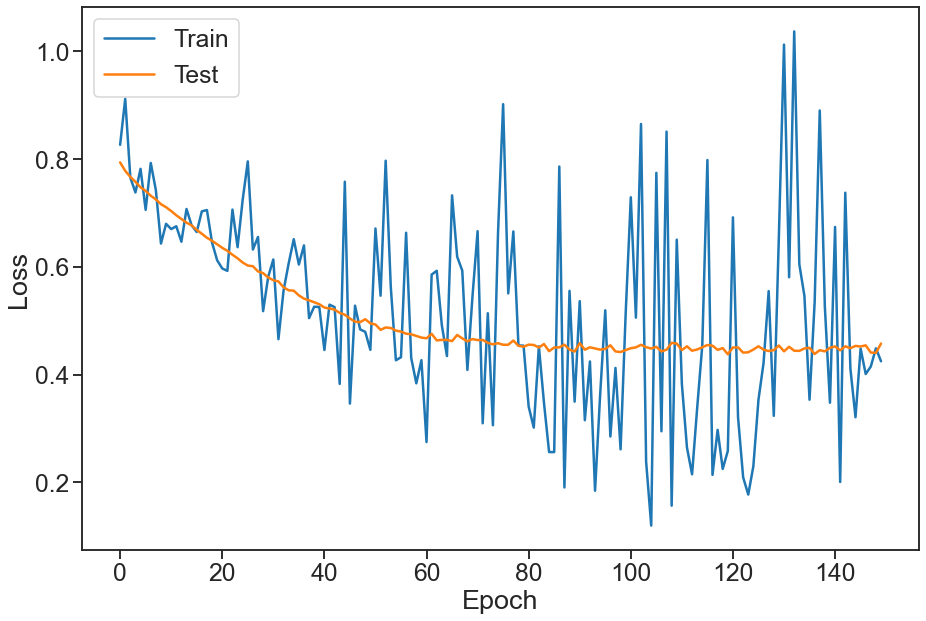

In [34]:
train_losses = [l.item() for l in train_losses]
test_losses = [l for l in test_losses]

## Plotando as curvas de treino e validação
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import accuracy_score, confusion_matrix

model.eval()
with torch.no_grad():
    y_pred = model(torch.FloatTensor(X_val).to(device)).squeeze(1).round().cpu().numpy()

accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 79.78%


Text(50.5, 0.5, 'True')

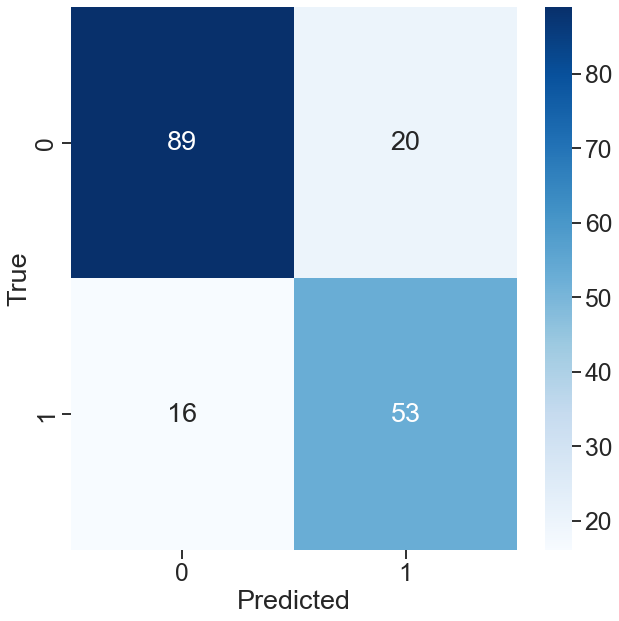

In [42]:
cm = confusion_matrix(y_val, y_pred)
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')